In [20]:
# Import modules
from os.path import join as opj
from nipype.interfaces.ants import Registration
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from IPython.display import Image

In [21]:
# Specify variables
experiment_dir = '/home/neuro/Result/Visual_search_task/preproc_working_dir/warp_field'
output_dir = 'antsdir'
working_dir = 'workingdir'
subject_list = ['%02d'%i for i in range(1,23)]

In [22]:
template = Info.standard_image('MNI152_T1_1mm.nii.gz')

In [23]:
# Registration - computes registration between subject's anatomy & the MNI template
antsreg = Node(Registration(args='--float',
                            collapse_output_transforms=True,
                            fixed_image=template,
                            initial_moving_transform_com=True,
                            num_threads=4,
                            output_inverse_warped_image=True,
                            output_warped_image=True,
                            sigma_units=['vox'] * 3,
                            transforms=['Rigid', 'Affine', 'SyN'],
                            terminal_output='file',
                            winsorize_lower_quantile=0.005,
                            winsorize_upper_quantile=0.995,
                            convergence_threshold=[1e-06],
                            convergence_window_size=[10],
                            metric=['MI', 'MI', 'CC'],
                            metric_weight=[1.0] * 3,
                            number_of_iterations=[[1000, 500, 250, 100],
                                                  [1000, 500, 250, 100],
                                                  [100, 70, 50, 20]],
                            radius_or_number_of_bins=[32, 32, 4],
                            sampling_percentage=[0.25, 0.25, 1],
                            sampling_strategy=['Regular', 'Regular', 'None'],
                            shrink_factors=[[8, 4, 2, 1]] * 3,
                            smoothing_sigmas=[[3, 2, 1, 0]] * 3,
                            transform_parameters=[(0.1,), (0.1,),
                                                  (0.1, 3.0, 0.0)],
                            use_histogram_matching=True,
                            write_composite_transform=True),
               name='antsreg')

# Input & Output Stream

In [24]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

In [25]:
# SelectFiles - to grab the data (alternative to DataGrabber)
anat_file = 'sub-{subject_id}/ses-test/anat/sub-{subject_id}_ses-test_anat_sT1W.nii'
templates = {'anat': anat_file}

selectfiles = Node(SelectFiles(templates, base_directory='/home/neuro/Data/Visual_search_task/BIDS_data'),
                   name="selectfiles")

In [26]:
# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
datasink.inputs.substitutions = substitutions

# Specify Normalization Workflow & Connect Nodes

In [27]:
# Initiation of the ANTS normalization workflow
regflow = Workflow(name='regflow')
regflow.base_dir = opj(experiment_dir, working_dir)

# Connect workflow nodes
regflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                 (selectfiles, antsreg, [('anat', 'moving_image')]),
                 (antsreg, datasink, [('warped_image', 'warped_image'),
                                      ('inverse_warped_image', 'inverse_warped_image'),
                                      ('composite_transform', 'transform'),
                                      ('inverse_composite_transform', 'inverse_transform')]),
                 ])

211113-14:20:59,973 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/preproc_working_dir/warp_field/workingdir/regflow/graph.png (graph2use=flat, simple_form=True).


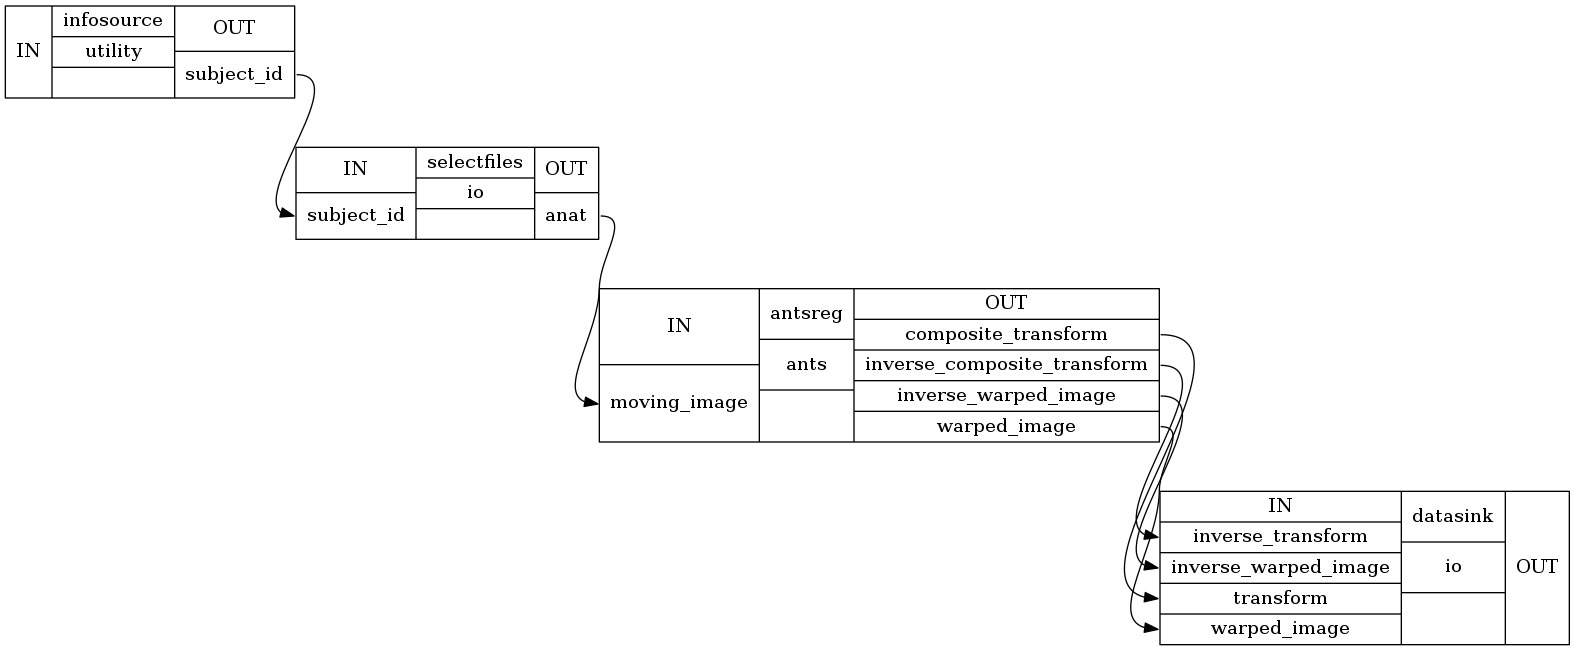

In [28]:
regflow.write_graph(graph2use='flat')
Image('/home/neuro/Result/Visual_search_task/preproc_working_dir/warp_field/workingdir/regflow/graph_detailed.png')

# Run Workflow

In [29]:
regflow.write_graph(graph2use='flat')
regflow.run('MultiProc', plugin_args={'n_procs': 5})

211113-14:21:02,181 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/preproc_working_dir/warp_field/workingdir/regflow/graph.png (graph2use=flat, simple_form=True).
211113-14:21:02,184 nipype.workflow INFO:
	 Workflow regflow settings: ['check', 'execution', 'logging', 'monitoring']
211113-14:21:02,295 nipype.workflow INFO:
	 Running in parallel.
211113-14:21:02,298 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 22 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 5/5.
211113-14:21:02,358 nipype.workflow INFO:
	 [Node] Setting-up "regflow.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/warp_field/workingdir/regflow/_subject_id_22/selectfiles".
211113-14:21:02,365 nipype.workflow INFO:
	 [Node] Setting-up "regflow.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/warp_field/workingdir/regflow/_subject_id_21/selectfiles".
211113-14:21:02,370 nipype.workflow INFO:
	 [Node] Settin